Central Accuracy: 0.0164
FedAvg Accuracy: 0.9836
FSGD Accuracy: 0.9836
DP Accuracy: 0.9836
Transfer Accuracy: 0.0164


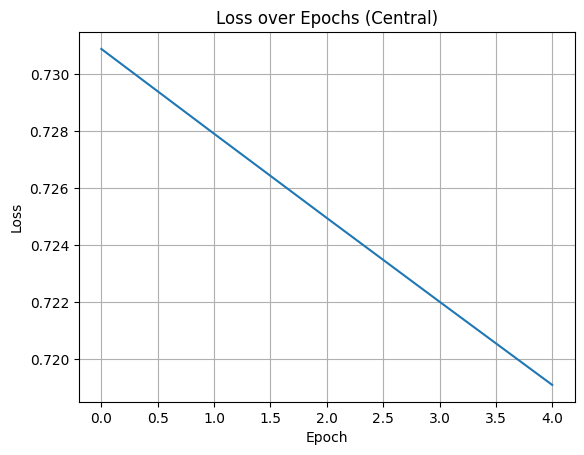

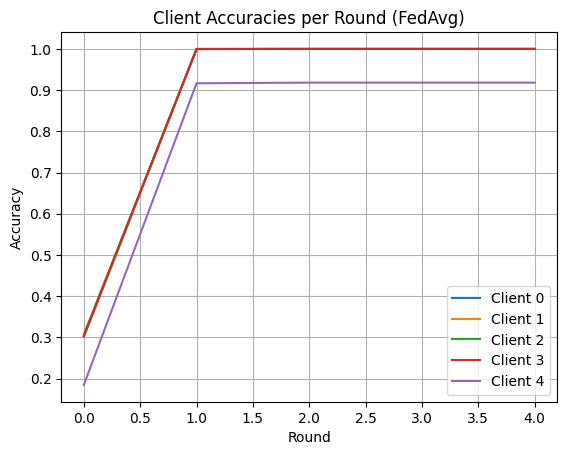

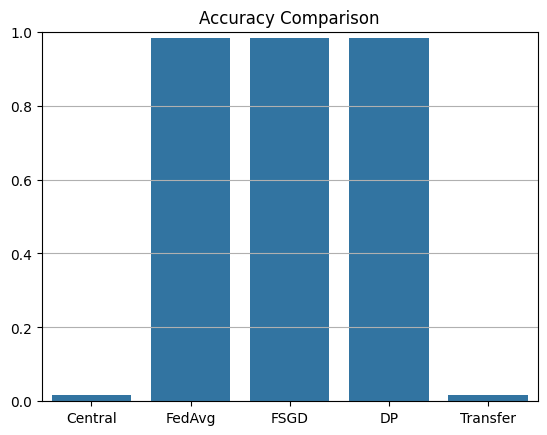

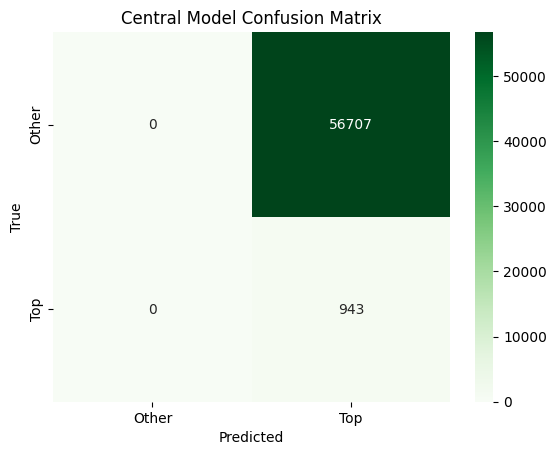

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from collections import defaultdict

# Load dataset
df = pd.read_csv("/content/spotify_millsongdata_modified - spotify_millsongdata_modified.csv")
df = df[['artist', 'text']]
df.dropna(inplace=True)

# Only focus on top 5 most common artists
top_artists = df['artist'].value_counts().index[:5]
df['label'] = df['artist'].apply(lambda x: 1 if x in top_artists else 0)

# Convert text to TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['text']).toarray()
y = df['label'].values

# Split data by label for federated-ish scenario (not real-world, just for testing)
clients = {}
indices = np.argsort(y)
splits = np.array_split(indices, 5)
for i in range(5):
    idx = splits[i]
    clients[i] = {
        'X': X[idx],
        'y': y[idx]
    }

# Simple feedforward network
class LyricsClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)

# Training function
def train(model, X_data, y_data, lr=0.01, epochs=5, add_noise=False, noise_std=0.1, keep_loss=False):
    model.train()
    opt = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    losses = []

    for _ in range(epochs):
        x_tensor = torch.tensor(X_data, dtype=torch.float32)
        y_tensor = torch.tensor(y_data.reshape(-1, 1), dtype=torch.float32)
        pred = model(x_tensor)
        loss = loss_fn(pred, y_tensor)
        opt.zero_grad()
        loss.backward()

        if add_noise:
            for p in model.parameters():
                p.grad += noise_std * torch.randn_like(p.grad)

        opt.step()
        if keep_loss:
            losses.append(loss.item())

    return (model, losses) if keep_loss else model

# Evaluation
def test(model, X_data, y_data):
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(X_data, dtype=torch.float32)
        pred = model(x_tensor).numpy()
        pred_label = (pred > 0.5).astype(int)
        acc = accuracy_score(y_data, pred_label)
    return acc, pred_label

# Train central model
central = LyricsClassifier(X.shape[1])
central, loss_hist = train(central, X, y, keep_loss=True)
acc_central, yhat_central = test(central, X, y)
print(f"Central Accuracy: {acc_central:.4f}")

# FedAvg
fed_model = LyricsClassifier(X.shape[1])
fed_weights = copy.deepcopy(fed_model.state_dict())
fed_accs = []

for rnd in range(5):
    local_weights = []
    accs = []
    for c in range(5):
        m = LyricsClassifier(X.shape[1])
        m.load_state_dict(copy.deepcopy(fed_weights))
        m = train(m, clients[c]['X'], clients[c]['y'])
        acc, _ = test(m, clients[c]['X'], clients[c]['y'])
        accs.append(acc)
        local_weights.append(m.state_dict())
    fed_accs.append(accs)
    new_weights = copy.deepcopy(fed_weights)
    for key in fed_weights:
        new_weights[key] = sum([w[key] for w in local_weights]) / len(local_weights)
    fed_weights = new_weights
    fed_model.load_state_dict(fed_weights)

acc_fed, _ = test(fed_model, X, y)
print(f"FedAvg Accuracy: {acc_fed:.4f}")

# Federated SGD (FSGD)
fsgd_model = LyricsClassifier(X.shape[1])
state = fsgd_model.state_dict()
for c in range(5):
    m = LyricsClassifier(X.shape[1])
    m.load_state_dict(copy.deepcopy(state))
    m = train(m, clients[c]['X'], clients[c]['y'], epochs=1)
    state = m.state_dict()
fsgd_model.load_state_dict(state)
acc_fsgd, _ = test(fsgd_model, X, y)
print(f"FSGD Accuracy: {acc_fsgd:.4f}")

# Differential privacy (simple Gaussian noise)
dp_model = LyricsClassifier(X.shape[1])
dp_weights = dp_model.state_dict()
for c in range(5):
    m = LyricsClassifier(X.shape[1])
    m.load_state_dict(copy.deepcopy(dp_weights))
    m = train(m, clients[c]['X'], clients[c]['y'], add_noise=True)
    dp_weights = m.state_dict()
dp_model.load_state_dict(dp_weights)
acc_dp, _ = test(dp_model, X, y)
print(f"DP Accuracy: {acc_dp:.4f}")

# Transfer learning
transfer_model = LyricsClassifier(X.shape[1])
transfer_model.load_state_dict(central.state_dict())
transfer_model = train(transfer_model, clients[0]['X'], clients[0]['y'], epochs=3)
acc_transfer, _ = test(transfer_model, X, y)
print(f"Transfer Accuracy: {acc_transfer:.4f}")

# --- Visualizations ---
#The graph shows a steady decrease in loss over the epochs:
#From ~0.731 to ~0.719.
#This means the model is learning and improving during training.
plt.figure()
plt.plot(loss_hist)
plt.title("Loss over Epochs (Central)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Accuracy per client per round
#Each colored line represents one client (0–4).
#All clients show rapid accuracy improvement in just the first round:
#Clients 0, 1, 2, and 3 reach 100% accuracy by round 1 and stay there.
#Client 4 reaches ~92% by round 1 and remains stable.
fed_accs = np.array(fed_accs)
plt.figure()
for c in range(5):
    plt.plot(fed_accs[:, c], label=f"Client {c}")
plt.title("Client Accuracies per Round (FedAvg)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Comparison
methods = ['Central', 'FedAvg', 'FSGD', 'DP', 'Transfer']
#Central – Single model trained on the entire dataset at once.
#FedAvg – Federated Averaging (combines models from all clients each round).
#FSGD – Federated Stochastic Gradient Descent (sequential model updates from clients).
#DP – Differential Privacy (adds noise to protect data during training).
#Transfer – Fine-tuning a pretrained central model on just one client’s data.
scores = [acc_central, acc_fed, acc_fsgd, acc_dp, acc_transfer]
sns.barplot(x=methods, y=scores)
plt.title("Accuracy Comparison")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Confusion matrix
cm = confusion_matrix(y, yhat_central)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Other', 'Top'], yticklabels=['Other', 'Top'])
plt.title("Central Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
#True Negatives (TN): 0 → The model never predicted "Other" when it was actually "Other".
#True Positives (TP): 943 → The model correctly predicted "Top" songs.
#False Positives (FP): 56,707 → The model incorrectly predicted "Top" when the song was actually "Other".
#False Negatives (FN): 0 → The model never predicted "Other" when the song was actually "Top"